Quantum Fourier Transform Benchmark Program - Cirq
... using circuit method 3
... execution starting at Sep 24, 2024 12:10:23 UTC
************
Executing [2] circuits with num_qubits = 2
... number of gates, depth = 7, 5


/home/cdac/Girish/Quantum_Computing_Benchmarks-master/qc-app-oriented-benchmarks/quantum-fourier-transform/cirq/../../_common/metrics.py:744: RuntimeWarning: divide by zero encountered in scalar divide
  rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
/home/cdac/Girish/Quantum_Computing_Benchmarks-master/qc-app-oriented-benchmarks/quantum-fourier-transform/cirq/../../_common/metrics.py:744: RuntimeWarning: divide by zero encountered in scalar divide
  rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
/home/cdac/Girish/Quantum_Computing_Benchmarks-master/qc-app-oriented-benchmarks/quantum-fourier-transform/cirq/../../_common/metrics.py:744: RuntimeWarning: divide by zero encountered in scalar divide
  rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1


Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 8, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 4, 0, 0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.001, 0.173, 0.015 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 0.5

************
Executing [3] circuits with num_qubits = 3
... number of gates, depth = 12, 8
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 11, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 6, 0, 0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.0, 0.042, 0.003 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.999, 0.666

************
Executing [3] circuits with num_qubits = 4
... number of gates, depth = 18, 12
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 14, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 8, 0, 0
Average Creati

/home/cdac/Girish/Quantum_Computing_Benchmarks-master/qc-app-oriented-benchmarks/quantum-fourier-transform/cirq/../../_common/metrics.py:744: RuntimeWarning: divide by zero encountered in scalar divide
  rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1


Average Circuit Algorithmic Depth, ξ (xi) for the 5 qubit group = 17, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 5 qubit group = 11, 0, 0
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.0, 0.113, 0.004 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 0.997, 0.666

************
Executing [3] circuits with num_qubits = 6
... number of gates, depth = 33, 23
Average Circuit Algorithmic Depth, ξ (xi) for the 6 qubit group = 20, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 6 qubit group = 13, 0, 0
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.0, 0.162, 0.004 secs
Average Hellinger, Normalized Fidelity for the 6 qubit group = 0.997, 0.994

************
Executing [3] circuits with num_qubits = 7
... number of gates, depth = 42, 30
Average Circuit Algorithmic Depth, ξ (xi) for the 7 qubit group = 23, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 7 qubit group = 15, 0, 0
Average

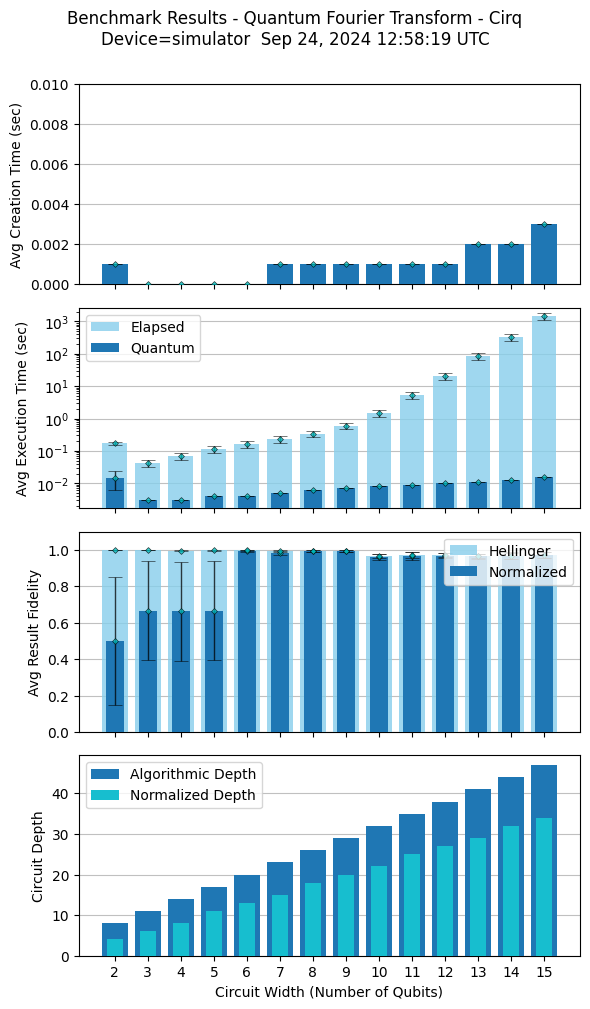

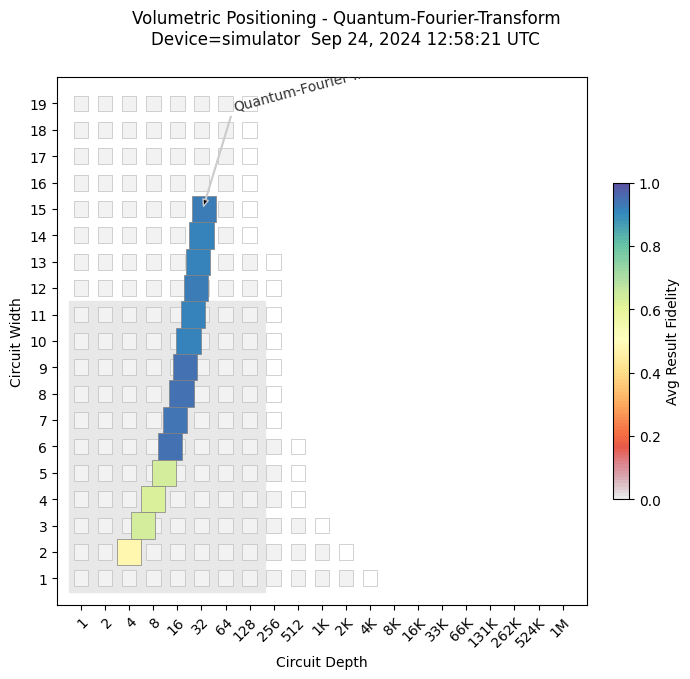

In [1]:
"""
Quantum Fourier Transform Benchmark Program - Cirq
"""

from collections import defaultdict
import math
import sys
import time

import cirq
import numpy as np

sys.path[1:1] = [ "_common", "_common/cirq" ]
sys.path[1:1] = [ "../../_common", "../../_common/cirq" ]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
num_gates = 0
depth = 0
QC_ = None
QFT_ = None
QFTI_ = None

############### Circuit Definition

def QuantumFourierTransform (num_qubits, secret_int, method=1):
    global num_gates, depth
    # Size of input is one less than available qubits
    input_size = num_qubits
    num_gates = 0
    depth = 0
    
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(num_qubits)]
    qc = cirq.Circuit()
    
    if method==1:

        # Perform X on each qubit that matches a bit in secret string
        s = ('{0:0'+str(input_size)+'b}').format(secret_int)
        for i_qubit in range(input_size):
            if s[input_size-1-i_qubit]=='1':
                qc.append(cirq.X(qr[i_qubit]))
                num_gates += 1
                
        depth += 1

        # perform QFT on the input
        qc.append(qft_gate(input_size).on(*qr))

        # End with Hadamard on all qubits (to measure the z rotations)
        ''' don't do this unless NOT doing the inverse afterwards
        for i_qubit in range(input_size):
             qc.h(qr[i_qubit])
            
        qc.barrier()
        '''
        
        # some compilers recognize the QFT and IQFT in series and collapse them to identity;
        # perform a set of rotations to add one to the secret_int to avoid this collapse
        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.append(cirq.rz( 1 * math.pi / divisor).on(qr[i_q]))
            num_gates+=1
        
        # to revert back to initial state, apply inverse QFT
        qc.append(inv_qft_gate(input_size).on(*qr))

    elif method == 2:

        for i_q in range(0, num_qubits):
            qc.append(cirq.H(qr[i_q]))
            num_gates += 1

        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.append(cirq.rz(secret_int * math.pi / divisor)(qr[i_q]))
            num_gates += 1

        depth += 1

        qc.append(inv_qft_gate(input_size).on(*qr))

    # This method is a work in progress
    elif method==3:

        for i_q in range(0, secret_int):
            qc.append(cirq.H(qr[i_q]))
            num_gates+=1

        for i_q in range(secret_int, num_qubits):
            qc.append(cirq.X(qr[i_q]))
            num_gates+=1
            
        depth += 1
        
        qc.append(inv_qft_gate(input_size).on(*qr))

    else:
        exit("Invalid QFT method")

        
    # measure all qubits
    qc.append(cirq.measure(*[qr[i_qubit] for i_qubit in range(num_qubits)], key='result'))   
    num_gates += num_qubits
    depth += 1

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc

def qft_gate(input_size):
    global QFT_, num_gates, depth
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(input_size)]
    qc = cirq.Circuit()

    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in range(0, input_size):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in range(0, num_crzs):
                divisor = 2 ** (num_crzs - j)
                qc.append(cirq.CZ(qr[hidx],qr[input_size - j - 1])**(1.0/divisor))
                num_gates += 1
                depth += 1
            
        # followed by an H gate (applied to all qubits)
        qc.append(cirq.H(qr[hidx]))
        num_gates += 1
        depth += 1

    if QFT_ == None or input_size <= 5:
        if input_size < 9: QFT_ = qc
        
    return cirq_utils.to_gate(num_qubits=input_size, circ=qc, name="qft")
        
############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    # allocate qubits
    qr = [cirq.GridQubit(i, 0) for i in range(input_size)]
    qc = cirq.Circuit()

    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.append(cirq.H(qr[hidx]))
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                qc.append(cirq.CZ(qr[hidx],qr[input_size - j - 1])**(-1.0/divisor))
                num_gates += 1
                depth += 1

    if QFTI_ == None or input_size <= 5:
        if input_size < 9: QFTI_ = qc
        
    return cirq_utils.to_gate(num_qubits=input_size, circ=qc, name="inv_qft")
    
# Define expected distribution calculated from applying the iqft to the prepared secret_int state
def expected_dist(num_qubits, secret_int, counts):
    dist = {}
    s = num_qubits - secret_int
    for key in counts.keys():
        if key[(num_qubits-secret_int):] == ''.zfill(secret_int):
            dist[key] = 1/(2**s)
    return dist

############### Result Data Analysis

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, secret_int, num_shots, method):
    
    # get measurement array and shot count
    measurements = result.measurements['result']
    num_shots = len(measurements)

    # create counts distribution
    counts = defaultdict(lambda: 0)
    for row in measurements:
        counts["".join([str(x) for x in reversed(row)])] += 1
        
    # For method 1, expected result is always the secret_int
    if method==1:
        
        # add one to the secret_int to compensate for the extra rotations done between QFT and IQFT
        secret_int_plus_one = (secret_int + 1) % (2 ** num_qubits)

        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int_plus_one, f"0{num_qubits}b")

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key: 1.0}
        
    # For method 2, expected result is always the secret_int
    elif method==2:

        # create the key that is expected to have all the measurements (for this circuit)
        key = format(secret_int, f"0{num_qubits}b")

        # correct distribution is measuring the key 100% of the time
        correct_dist = {key: 1.0}
    
    # For method 3, correct_dist is a distribution with more than one value
    elif method==3:

        # correct_dist is from the expected dist
        correct_dist = expected_dist(num_qubits, secret_int, counts)
            
    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    if verbose: print(f"For secret int {secret_int} measured: {counts} fidelity: {fidelity}")

    return counts, fidelity
    
    
################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits = 2, max_qubits = 15, max_circuits = 3, num_shots=1000,
        method=3, backend_id='simulator', provider_backend=None):

    print("Quantum Fourier Transform Benchmark Program - Cirq")
    print(f"... using circuit method {method}")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, input_size, s_int, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(input_size)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots, method)
        metrics.store_metric(input_size, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for input_size in range(min_qubits, max_qubits + 1):
        
        num_qubits = input_size

        # determine number of circuits to execute for this group
        # and determine range of secret strings to loop over
        if method == 1 or method == 2:
            num_circuits = min(2 ** (input_size), max_circuits)
        
            if 2**(input_size) <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(2**(input_size), num_circuits, False)

        elif method == 3:
            num_circuits = min(input_size, max_circuits)
        
            if input_size <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(range(input_size), num_circuits, False)

        else:
            exit("Invalid QFT method")

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
        
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = QuantumFourierTransform(num_qubits, s_int, method=method)
            metrics.store_metric(input_size, s_int, 'create_time', time.time()-ts)

            qc = cirq.Circuit(cirq.decompose(op) for op in qc.all_operations())
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, input_size, s_int, num_shots)
        
        print(f"... number of gates, depth = {num_gates}, {depth}")
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(input_size)
        metrics.report_metrics_for_group(input_size)
        

    # Alternatively, execute all circuits, aggregate and report metrics
    #ex.execute_circuits()
    #metrics.aggregate_metrics_for_group(input_size)
    #metrics.report_metrics_for_group(input_size)

    # print a sample circuit created (if not too large)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method==1:
        print("\nQFT Circuit ="); print(QFT_)
    print("\nInverse QFT Circuit ="); print(QFTI_)

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Quantum Fourier Transform - Cirq")

# if main, execute method    
if __name__ == '__main__': run()
